# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv',
               '../../data/cleaned/utah_2017_bird.csv']

test_files = ['../../data/cleaned/utah_2018_vineyard.csv', 
               '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']
x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

RFU_THRESHOLD = 2

train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[0].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [3]:
test_dfs[0].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 12:00,10.39,1885,-87.7,8.45,47.62,84.9,9.44,0.6
1,4/11/2018 12:15,11.67,1887,-89.3,8.48,43.17,90.4,9.75,0.5
2,4/11/2018 12:30,11.42,1890,-89.4,8.48,43.86,90.0,9.78,0.6
3,4/11/2018 12:45,11.40,1887,-89.7,8.49,43.42,89.6,9.73,0.6
4,4/11/2018 13:00,11.08,1885,-89.8,8.49,44.26,88.4,9.67,0.6


In [4]:
test_dfs[1].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [5]:
test_dfs[2].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 11:15,11.06,1874,-114.2,8.39,46.27,89.3,9.78,0.7
1,4/11/2018 11:30,10.98,1879,-114.2,8.39,46.55,89.2,9.78,0.8
2,4/11/2018 11:45,10.58,1865,-113.8,8.39,48.62,87.5,9.68,0.9
3,4/11/2018 12:00,10.67,1864,-114.1,8.39,47.96,88.0,9.72,0.8
4,4/11/2018 12:15,10.71,1864,-114.3,8.40,49.47,88.3,9.75,0.8


## Use Datetime Index

In [6]:
print(test_dfs[0].dtypes)
print(train_dfs[0].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [7]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[0].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [8]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[0].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 12:00:00,10.39,1885,-87.7,8.45,47.62,84.9,9.44,0.6,2018-04-11 12:00:00
2018-04-11 12:15:00,11.67,1887,-89.3,8.48,43.17,90.4,9.75,0.5,2018-04-11 12:15:00
2018-04-11 12:30:00,11.42,1890,-89.4,8.48,43.86,90.0,9.78,0.6,2018-04-11 12:30:00
2018-04-11 12:45:00,11.40,1887,-89.7,8.49,43.42,89.6,9.73,0.6,2018-04-11 12:45:00
2018-04-11 13:00:00,11.08,1885,-89.8,8.49,44.26,88.4,9.67,0.6,2018-04-11 13:00:00


## BGA RFU Levels

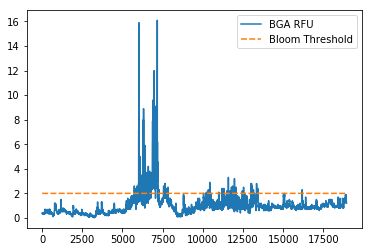

In [9]:
presegmented_plot = sns.lineplot(data=pd.DataFrame({
    'BGA RFU': train_dfs[0][target_column].values,
    'Bloom Threshold': np.full(train_dfs[0].count()[0], RFU_THRESHOLD)}))

In [10]:
def windowize(df, time_column):
    print("Segmenting...")
    x_windows, y_windows = hf.segment_dataset(df, time_column)
    print("Extracting feature windows...")
    x_windows = hf.extract_percentile(x_windows, time_column)
    print("Extracting target windows...")
    y_windows = hf.extract_percentile(y_windows, time_column)
    print("Combining extractions...")
    x_windows[target_column] = y_windows[target_column].values
    return x_windows

In [11]:
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i+1)
    train_dfs[i] = windowize(train_dfs[i], 'datetime')
    print("Windowizing 2018 data set:", i+1)
    test_dfs[i] = windowize(test_dfs[i], 'datetime')
    print()

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 2
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 2
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 3
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 3
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



In [12]:
presegmented_plot

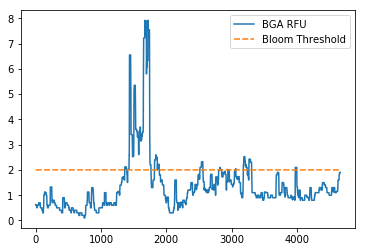

In [13]:
sns.lineplot(data=pd.DataFrame({
    'BGA RFU': train_dfs[0][target_column].values,
    'Bloom Threshold': np.full(train_dfs[0].count()[0], RFU_THRESHOLD)}))

## Greedy Model

In [14]:
lrf.add_target_column(train_dfs + test_dfs, threshold=RFU_THRESHOLD)

In [15]:
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_accuracy(train_dfs[0], 
                                            test_dfs[0],
                                            x_columns,
                                            'bloom')

Training model with: Temp C


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.8780996040841842
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[4214    0]
 [ 585    0]]

Training model with: Sp Cond (uS/cm)
Accuracy 0.8787247343196499
Recall: 0.005128205128205128
Precision 1.0
Confusion Matrix:
 [[4214    0]
 [ 582    3]]

Training model with: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.8780996040841842
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[4214    0]
 [ 585    0]]

Training model with: pH


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.8780996040841842
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[4214    0]
 [ 585    0]]

Training model with: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.8780996040841842
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[4214    0]
 [ 585    0]]

Training model with: ODOSat%
Accuracy 0.9037299437382789
Recall: 0.2905982905982906
Precision 0.783410138248848
Confusion Matrix:
 [[4167   47]
 [ 415  170]]

Training model with: ODO (mg/L)
Accuracy 0.903938320483434
Recall: 0.2923076923076923
Precision 0.7844036697247706
Confusion Matrix:
 [[4167   47]
 [ 414  171]]

ODO (mg/L) accuracy: 0.903938320483434
ODOSat% accuracy: 0.9037299437382789
Sp Cond (uS/cm) accuracy: 0.8787247343196499
Temp C accuracy: 0.8780996040841842
pH (mV) accuracy: 0.8780996040841842
pH accuracy: 0.8780996040841842
Turbidity (NTU) accuracy: 0.8780996040841842


In [16]:
#create greedy model
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    train_dfs[0], test_dfs[0], x_columns, 'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training model with: ['ODO (mg/L)']
Test model accuracy: 0.903938320483434
Test model recall: 0.2923076923076923
Test model precision: 0.7844036697247706

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.9037299437382789
Test model recall: 0.2905982905982906
Test model precision: 0.783410138248848

Training model with: ['ODO (mg/L)', 'Sp Cond (uS/cm)']
Test model accuracy: 0.8787247343196499
Test model recall: 0.005128205128205128
Test model precision: 1.0

Training model with: ['ODO (mg/L)', 'Temp C']
Test model accuracy: 0.9037299437382789
Test model recall: 0.2905982905982906
Test model precision: 0.783410138248848

Training model with: ['ODO (mg/L)', 'pH (mV)']
Test model accuracy: 0.8151698270473016
Test model recall: 0.3418803418803419
Test model precision: 0.2849002849002849

Updating greedy model

Training model with: ['ODO (mg/L)', 'pH (mV)', 'pH']
Test model accuracy: 0.47197332777662016
Test model recall: 0.17435897435897435
Test m

Model AUC: 0.6558


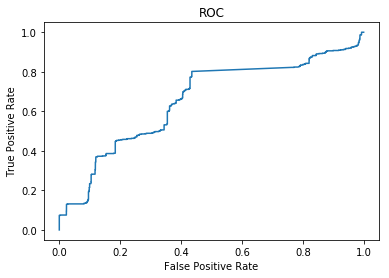

In [17]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[0][['bloom']].values, predictions)

## Cross training sites for comparison

In [18]:
avg_recall = 0
avg_precision = 0
train_index = 0
test_index = 0
for train in train_dfs:
    for test in test_dfs:
        print("Training on:", train_files[train_index])
        print("Testing on:", test_files[test_index])
        accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
            train, test, x_columns, 'bloom')
        avg_recall += recall
        avg_precision += precision
        print("Recall:", recall)
        print("Precision", precision)
        print("Confusion Matrix:\n", cm)
        print()
        test_index = (test_index + 1) % len(test_files)
    train_index += 1
num_models = len(train_dfs) * len(test_dfs)
print("Average Recall:", avg_recall / num_models)
print("Average Precision:", avg_precision / num_models)

Training on: ../../data/cleaned/utah_2017_vineyard.csv
Testing on: ../../data/cleaned/utah_2018_vineyard.csv
Recall: 0.17435897435897435
Precision 0.05209397344228805
Confusion Matrix:
 [[2358 1856]
 [ 483  102]]

Training on: ../../data/cleaned/utah_2017_vineyard.csv
Testing on: ../../data/cleaned/utah_2018_marina.csv


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[3213    0]
 [1588    0]]

Training on: ../../data/cleaned/utah_2017_vineyard.csv
Testing on: ../../data/cleaned/utah_2018_bird.csv


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[3123    0]
 [1676    0]]

Training on: ../../data/cleaned/utah_2017_marina.csv
Testing on: ../../data/cleaned/utah_2018_vineyard.csv
Recall: 0.1282051282051282
Precision 0.12605042016806722
Confusion Matrix:
 [[3694  520]
 [ 510   75]]

Training on: ../../data/cleaned/utah_2017_marina.csv
Testing on: ../../data/cleaned/utah_2018_marina.csv


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[3213    0]
 [1588    0]]

Training on: ../../data/cleaned/utah_2017_marina.csv
Testing on: ../../data/cleaned/utah_2018_bird.csv
Recall: 0.010739856801909307
Precision 1.0
Confusion Matrix:
 [[3123    0]
 [1658   18]]

Training on: ../../data/cleaned/utah_2017_bird.csv
Testing on: ../../data/cleaned/utah_2018_vineyard.csv
Recall: 0.07692307692307693
Precision 0.371900826446281
Confusion Matrix:
 [[4138   76]
 [ 540   45]]

Training on: ../../data/cleaned/utah_2017_bird.csv
Testing on: ../../data/cleaned/utah_2018_marina.csv


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[3213    0]
 [1588    0]]

Training on: ../../data/cleaned/utah_2017_bird.csv
Testing on: ../../data/cleaned/utah_2018_bird.csv
Recall: 0.024463007159904536
Precision 1.0
Confusion Matrix:
 [[3123    0]
 [1635   41]]

Average Recall: 0.04607667149433259
Average Precision: 0.2833383577840707
